<a href="https://colab.research.google.com/github/vanchanr/arXiv-analytics/blob/main/arXiv_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
keyword = input("Enter the keyword to search papers: ")

Enter the keyword to search papers: IoT


In [19]:
!pip3 install xmltodict
import xmltodict
import requests
import json
import time
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [20]:
def cleanSpaces(s):
    s = s.replace('\n', ' ')
    s = re.sub(r'\s\s+', ' ', s)
    return s

def createPaper(paper):
    for field in ['author', 'category']:
        if type(paper[field]) is not list:
            paper[field] = [paper[field]]
    isCsPaper = False
    allCategories = []
    for category in paper['category']:
        allCategories.append(category['@term'])
        if category['@term'].startswith('cs.'):
            isCsPaper = True
    if isCsPaper:
        return {
            'title': cleanSpaces(paper['title']),
            'author': [author['name'] for author in paper['author']],
            'abstract': cleanSpaces(paper['summary']),
            'lastUpdated': paper['updated'],
            'category': allCategories,
            'url': paper['id']
        }
    else:
        return None

def plotHelper(plotBy, countData):
    plt.bar(countData.keys(), countData.values())
    for key in countData:
        plt.text(key, countData[key], str(countData[key]), va='bottom', ha='center')
    plt.title(f'Number of {keyword} Papers by {plotBy}')
    plt.xlabel(plotBy)
    plt.ylabel('Count')
    plt.xticks(rotation=30)
    plt.show()

def plotYearWise(jsonDump):
    yearCountData = {}
    for paper in jsonDump:
        lastUpdated = paper['lastUpdated']
        dt = datetime.strptime(lastUpdated, '%Y-%m-%dT%H:%M:%SZ')
        year = str(dt.year)
        if year in yearCountData:
            yearCountData[year] += 1
        else:
            yearCountData[year] = 1
    
    yearCountData = dict(sorted(yearCountData.items()))
    plotHelper('year', yearCountData)

#field: 'author', 'category'
#plot top 10
def plotFieldWise(jsonDump, field):
    if field in ['author', 'category']:
        data = {}
        for paper in jsonDump:
            for name in paper[field]:
                if name in data:
                    data[name] += 1
                else:
                    data[name] = 1
        data = dict(sorted(data.items(), key=lambda x: x[1], reverse=True)[:10])
        plotHelper(field, data)

In [21]:
url = 'http://export.arxiv.org/api/query'
queryParams = {
    'search_query': f'all:"{keyword}"',
    'start': 0,
    'max_results': 500
}

outLs = []
batch = 1
while batch <= 100:
    try:
        resp = requests.get(url, params=queryParams)
        resp = xmltodict.parse(resp.text)
        resp = resp['feed']
        if 'entry' in resp:
            curBatch = []
            for paper in resp['entry']:
                paper = createPaper(paper)
                if paper is not None:
                    curBatch.append(paper)
            outLs.extend(curBatch)
            print(f"Batch-{batch}: Added {len(curBatch)} CS papers")
        else:
            break
    except Exception as ex:
        print(f"Error while processing batch-{batch}: {ex}")
    batch += 1
    queryParams['start'] += 500
    time.sleep(0.5)
print(f"Total CS papers matching '{keyword}':", len(outLs))
try:
    with open(f'{keyword}.json', mode='w', encoding='utf-8') as jsonFile:
        json.dump(outLs, jsonFile, indent=2, ensure_ascii=False)
        print("Successfully created the json dump file !")
except Exception as ex:
    print(f"Error while creating json dump file: {ex}")


Batch-1: Added 482 CS papers
Batch-2: Added 476 CS papers
Batch-3: Added 475 CS papers
Batch-4: Added 460 CS papers
Batch-5: Added 462 CS papers
Batch-6: Added 462 CS papers
Batch-7: Added 248 CS papers
Total CS papers matching 'IoT': 3065
Successfully created the json dump file !


In [22]:
jsonDump = {}
with open(f'{keyword}.json', mode='r') as jsonFile:
    jsonDump = json.load(jsonFile)

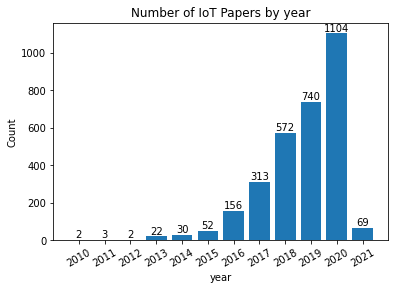

In [23]:
plotYearWise(jsonDump)

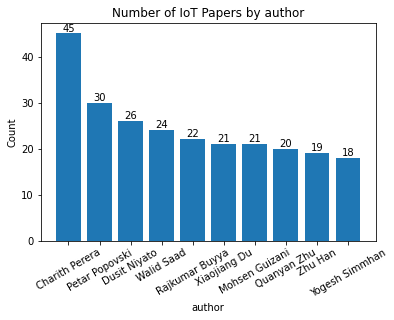

In [24]:
plotFieldWise(jsonDump, 'author')

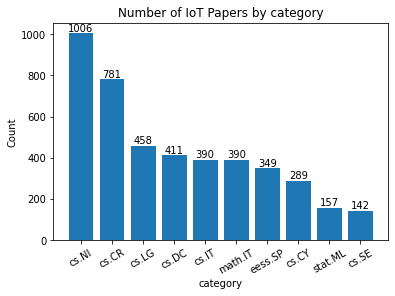

In [25]:
plotFieldWise(jsonDump, 'category')